## SHRINKAGE METHODS

## RIDGE REGRESSION: Hitters dataset

In [118]:
# Riduce mean squared error di test (coefficienti non vanno esattamente a 0) 
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error



import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.model_selection import train_test_split

In [119]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

null_rows = Food.isnull().any(axis=1).sum()
print("Number of rows with missing values:", null_rows)

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()

Number of rows in the original dataset: 1000
Number of rows with missing values: 117
Number of rows after removing missing values: 883


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


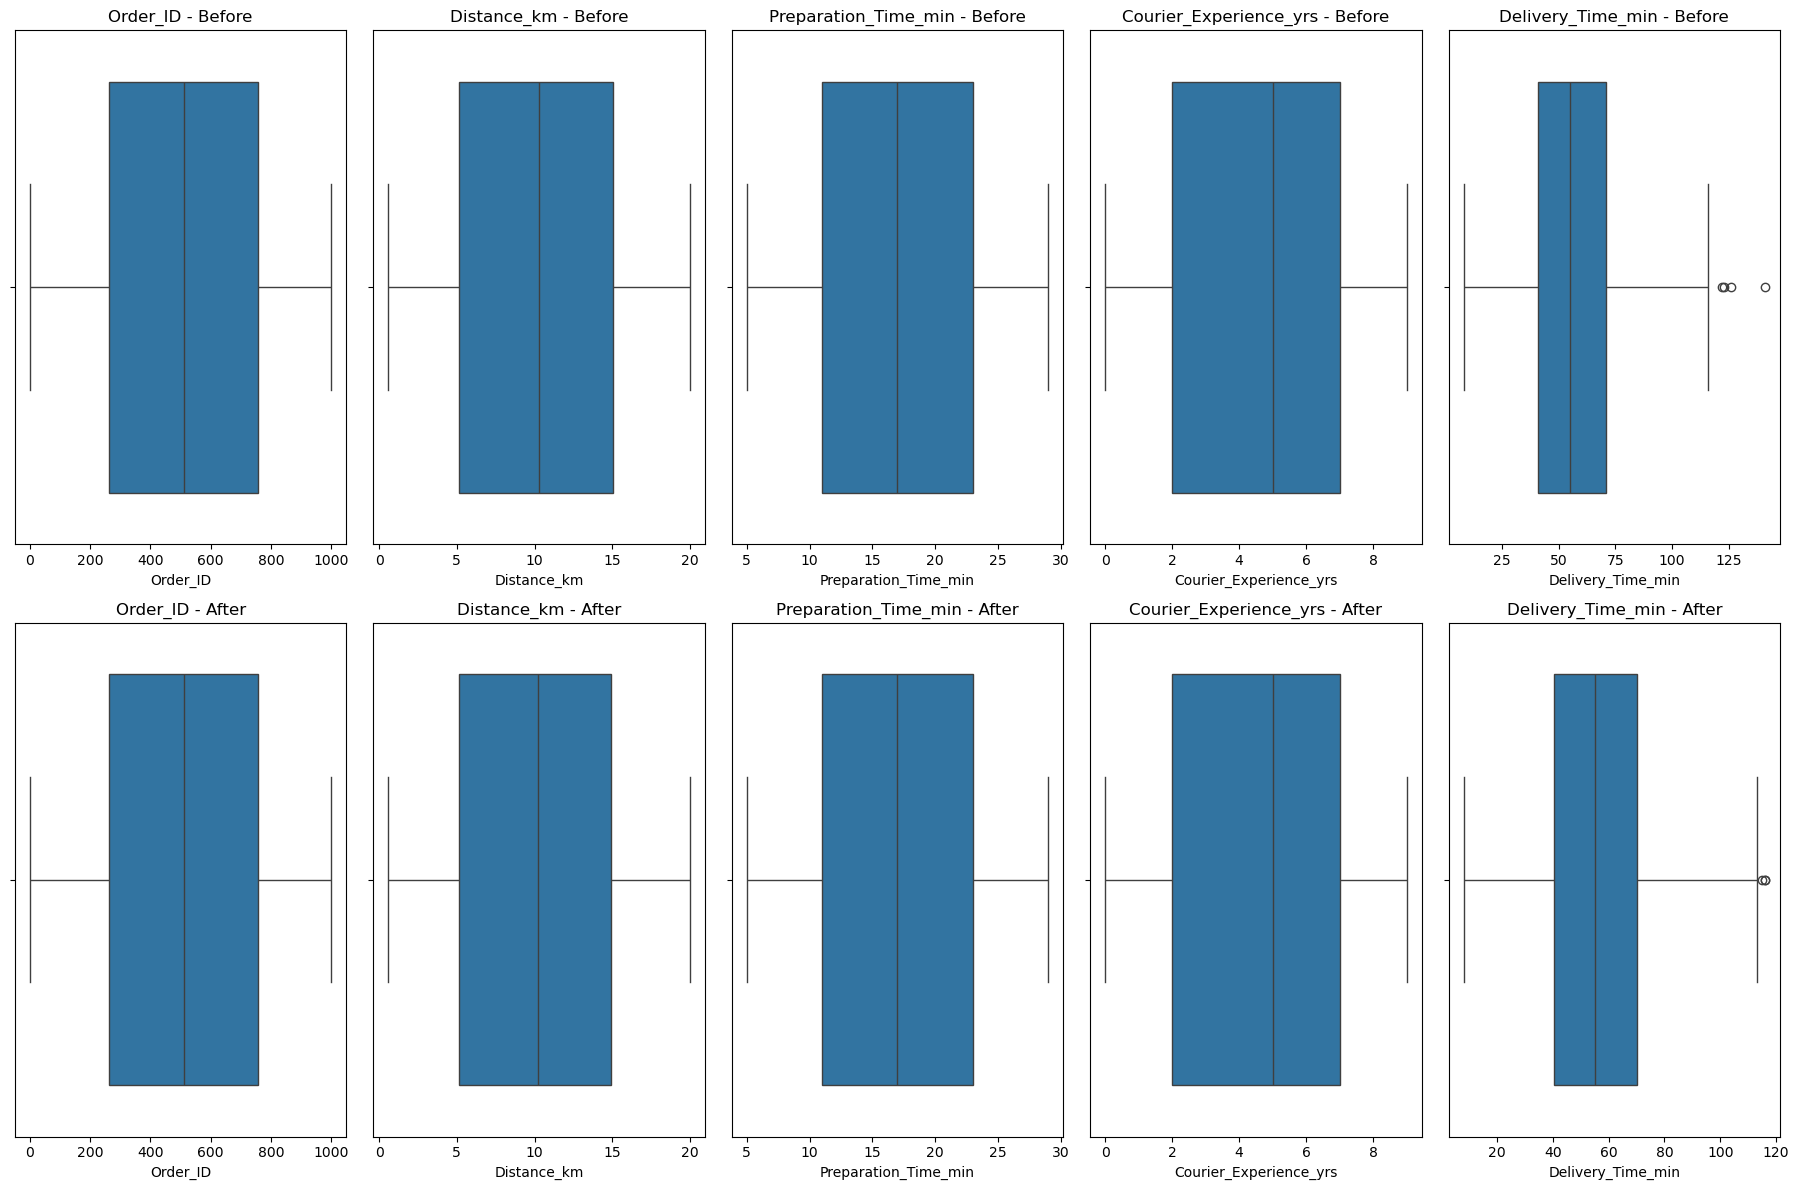

Number of rows after removing outliers 879


In [120]:
numeric_columns = Food.select_dtypes(include=['float64', 'int64']).columns

Food_original = Food.copy()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    Food = remove_outliers(Food, col)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns, 1):

    plt.subplot(2, len(numeric_columns), i)
    sns.boxplot(x=Food_original[col])
    plt.title(f"{col} - Before")

    plt.subplot(2, len(numeric_columns), len(numeric_columns) + i)
    sns.boxplot(x=Food[col])
    plt.title(f"{col} - After")

plt.tight_layout()
plt.show()

print("Number of rows after removing outliers", len(Food))

In [121]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,18.4314,1.467,12.564,0.000
Distance_km,2.9055,0.056,51.622,0.000
Weather[Foggy],8.0616,1.059,7.611,0.000
Weather[Rainy],4.9402,0.832,5.938,0.000
Weather[Snowy],10.2738,1.126,9.128,0.000
Weather[Windy],1.9968,1.129,1.769,0.077
Traffic_Level[Low],-12.2613,0.869,-14.102,0.000
Traffic_Level[Medium],-6.0433,0.865,-6.984,0.000
Time_of_Day[Evening],0.0829,0.826,0.100,0.920
Time_of_Day[Morning],-0.8775,0.817,-1.074,0.283


In [122]:
residuals = results.resid

residuals_std = np.std(residuals)
threshold = 2.9 * residuals_std

mask = np.abs(residuals) < threshold
Food = Food.loc[mask].copy()

print(f"Number of rows after removing outliers: {len(Food)}")

Number of rows after removing outliers: 860


In [123]:
from sklearn.preprocessing import StandardScaler

# Definisci le variabili categoriali
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

# Crea il modello
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

# Trasforma i dati
X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

# Identifica le variabili numeriche per la normalizzazione
numerical_columns = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

# Normalizza solo le variabili numeriche
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])


# Modello di regressione
model = sm.OLS(y, X)
results = model.fit()

# Sommario dei risultati
summarize(results)


,coef,std err,t,P>|t|
intercept,59.5537,0.701,84.955,0.000
Distance_km,16.8426,0.228,73.852,0.000
Weather[Foggy],6.3464,0.768,8.264,0.000
Weather[Rainy],4.7687,0.593,8.044,0.000
Weather[Snowy],9.8532,0.804,12.262,0.000
Weather[Windy],2.8989,0.798,3.633,0.000
Traffic_Level[Low],-11.2475,0.623,-18.066,0.000
Traffic_Level[Medium],-5.3621,0.620,-8.653,0.000
Time_of_Day[Evening],-0.3425,0.591,-0.580,0.562
Time_of_Day[Morning],-0.5390,0.581,-0.927,0.354


In [124]:


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Define lambda values for regularization
lambda_values = np.logspace(0, 1, 500) # da 10^-2 a 10^3, 150 valori

In [125]:
# Create Ridge pipeline with scaling
pipeline = make_pipeline(StandardScaler(), Ridge())

# Grid search for best alpha
param_grid = {'ridge__alpha': lambda_values}
ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10) # key-fold con 10 valori
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best Ridge alpha: {best_alpha}")


Best Ridge alpha: 1.805148879221109


In [126]:
# Evaluate on test set
ridge_best = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f"Ridge Test MSE: {ridge_mse:.2f}")

Ridge Test MSE: 41.91


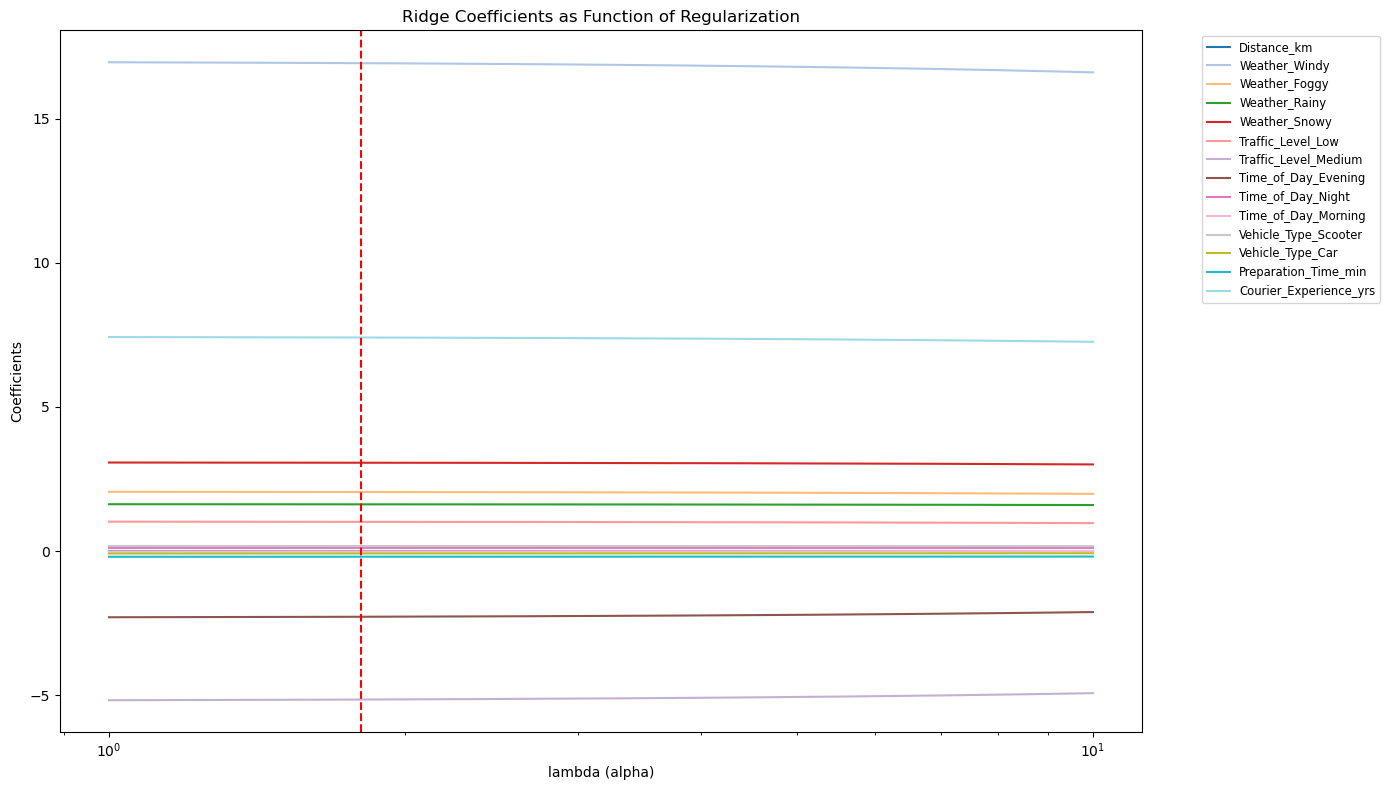

In [127]:
feature_names = [
    'Distance_km',
    'Weather_Windy', 'Weather_Foggy', 'Weather_Rainy', 'Weather_Snowy',
    'Traffic_Level_Low', 'Traffic_Level_Medium',
    'Time_of_Day_Evening', 'Time_of_Day_Night', 'Time_of_Day_Morning',
    'Vehicle_Type_Scooter', 'Vehicle_Type_Car',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
]

# Lista per salvare i coefficienti
coefs = []

# Esegui Ridge Regression per ogni valore di lambda
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=a))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

coefs = np.array(coefs)  # Trasforma in array per gestirlo facilmente

# Plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Usa un colore diverso per ogni linea
colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))

for idx, name in enumerate(feature_names):
    ax.plot(lambda_values, coefs[:, idx], label=name, color=colors[idx])

ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.axvline(best_alpha, color='r', linestyle='--')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as Function of Regularization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Legenda fuori dal grafico
plt.tight_layout()
plt.show()

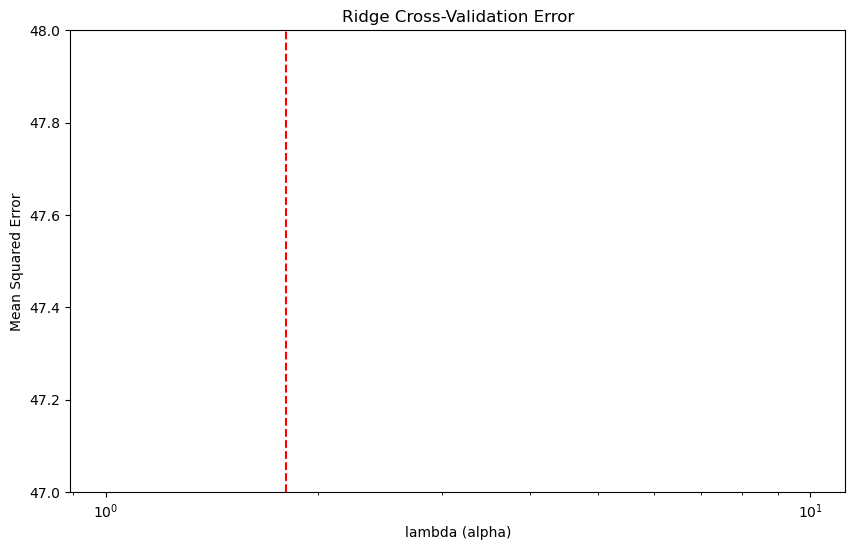

In [128]:
# Plot cross-validation errors
cv_scores = []
for alpha in lambda_values:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = -cross_val_score(pipe, X_train, y_train, cv=kf, 
                             scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, cv_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel('lambda (alpha)')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Error')
plt.ylim(47, 48)
plt.show()
# Trovo il minimo di lambda. Se vado avanti il modello diventa inutile perchè mando tutto a zero
# Tornando al grafico sopra nel minimo vedo che rossa e grigia sono le variabili da tenere

## LASSO 

In [129]:
# Riduce mean squared error mandando esattamente a zero i coefficienti
# Meglio ridge ma la lasso permette di semplificare il modello
# Create Lasso pipeline with scaling
lasso_pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))


# Grid search for best alpha
lasso_cv = GridSearchCV(lasso_pipe, 
                       {'lasso__alpha': lambda_values},
                       scoring='neg_mean_squared_error',
                       cv=10)
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.best_params_['lasso__alpha']
print(f"Best Lasso alpha: {best_alpha}")

KeyboardInterrupt: 

In [ ]:
# Evaluate on test set
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f"Lasso Test MSE: {lasso_mse:.2f}")

# Number of non-zero coefficients
final_coefs = lasso_best.named_steps['lasso'].coef_
print(f"Number of non-zero coefficients: {np.sum(final_coefs != 0)}")

Lasso Test MSE: 45.05
Number of non-zero coefficients: 11


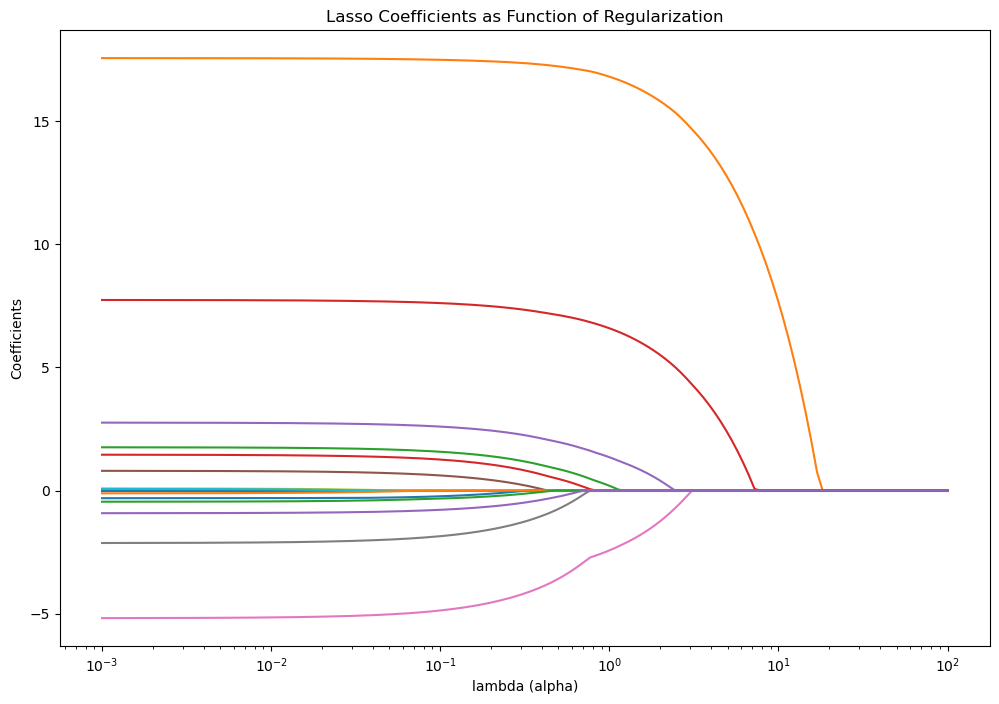

In [ ]:
# Plot Lasso coefficients for different lambda values
coefs = []
for a in lambda_values:
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=a, max_iter=10000))
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['lasso'].coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(lambda_values, coefs)
ax.set_xscale('log')
plt.xlabel('lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as Function of Regularization')
plt.show()
# Se ci sono covariate speculari probabilmente sono dipendenti tra loro o portano stessa informazione
